In [41]:
import pandas as pd 
import numpy as np 
import seaborn as sns 
sns.set(style='dark', palette='muted', color_codes=True)
import matplotlib.pyplot as plt 
plt.style.use('ggplot')
import plotly.express as px

In [42]:
from sklearn.model_selection import train_test_split 
from sklearn.metrics import r2_score, accuracy_score, mean_squared_error, confusion_matrix, silhouette_score 
from sklearn.linear_model import LogisticRegression,LinearRegression 
from sklearn.preprocessing import LabelEncoder,OrdinalEncoder,OneHotEncoder,MinMaxScaler,StandardScaler 
from sklearn.compose import ColumnTransformer 
from sklearn.decomposition import PCA 
from sklearn.pipeline import Pipeline 
from sklearn.cluster import KMeans 
from sklearn.ensemble import RandomForestRegressor 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.impute import SimpleImputer

In [43]:
data = pd.read_csv(r'c:\Github\Sol\the_data\data-lab-5-hcv.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 615 entries, 0 to 614
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  615 non-null    int64  
 1   Category    615 non-null    object 
 2   Age         615 non-null    int64  
 3   Sex         615 non-null    object 
 4   ALB         614 non-null    float64
 5   ALP         597 non-null    float64
 6   ALT         614 non-null    float64
 7   AST         615 non-null    float64
 8   BIL         615 non-null    float64
 9   CHE         615 non-null    float64
 10  CHOL        605 non-null    float64
 11  CREA        615 non-null    float64
 12  GGT         615 non-null    float64
 13  PROT        614 non-null    float64
dtypes: float64(10), int64(2), object(2)
memory usage: 67.4+ KB


In [44]:
data.drop(columns=['Unnamed: 0'], inplace=True)

mis_val = data.isna().sum() * 100/len(data)
mis_val.sort_values(ascending=False)

ALP         2.926829
CHOL        1.626016
ALB         0.162602
ALT         0.162602
PROT        0.162602
Category    0.000000
Age         0.000000
Sex         0.000000
AST         0.000000
BIL         0.000000
CHE         0.000000
CREA        0.000000
GGT         0.000000
dtype: float64

In [45]:
mean_imp = SimpleImputer(strategy='mean', missing_values=np.NaN)
data[['ALP', 'CHOL', 'ALB', 'ALT', 'PROT']] = mean_imp.fit_transform(data[['ALP', 'CHOL', 'ALB', 'ALT', 'PROT']])

In [46]:
# data.drop(columns=['Unnamed: 0'], inplace=True)

mis_val = data.isna().sum() * 100/len(data)
mis_val.sort_values(ascending=False)

Category    0.0
Age         0.0
Sex         0.0
ALB         0.0
ALP         0.0
ALT         0.0
AST         0.0
BIL         0.0
CHE         0.0
CHOL        0.0
CREA        0.0
GGT         0.0
PROT        0.0
dtype: float64

<AxesSubplot:title={'center':'Correlation Matrix'}>

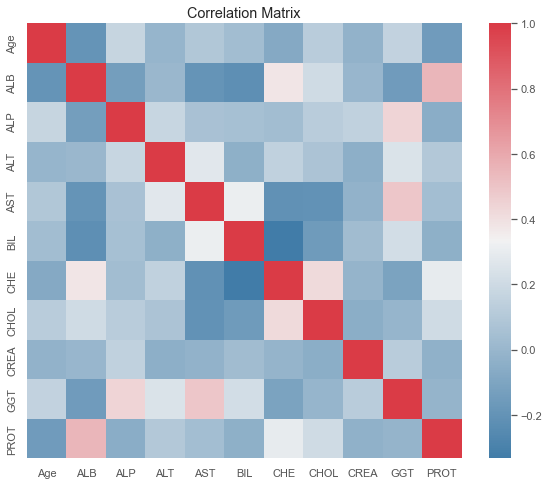

In [47]:
data_corr = data.corr()

f,ax = plt.subplots(figsize=(10,8))

ax.set_title('Correlation Matrix')

sns.heatmap(data_corr, mask=np.zeros_like(data_corr, dtype=np.bool_), cmap=sns.diverging_palette(240,10, as_cmap=True), ax=ax, square=True)